# Final Project - Deep Learning

### Opción 1: Proyecto Libre
#### Conjunto de datos: CIFAR-10

El conjunto de datos CIFAR-10 (Canadian Institute For Advanced Research) es una colección de imágenes muy utilizada para algoritmos de aprendizaje automático y visión por ordenador. Fue desarrollado por investigadores del instituto CIFAR y consta de 65.000 imágenes en color de 32x32 en 10 clases diferentes.

### 1. Descripción del problema o formulación de una pregunta de interés.

¿Puede una red neuronal convolucional (CNN) entrenada con el conjunto de datos CIFAR-10 lograr una precisión suficientemente alta en la clasificación de imágenes para ser utilizada como parte de un sistema de visión en vehículos autónomos, ayudando así a mejorar la detección y reconocimiento de objetos en tiempo real?

#### Librerías

In [1]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model


#### Carga de datos

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

### 2. Exploración de los datos para su entendimiento.

Tamaño del conjunto de entrenamiento: (50000, 32, 32, 3)
Tamaño del conjunto de prueba: (10000, 32, 32, 3)
Número de clases: 10


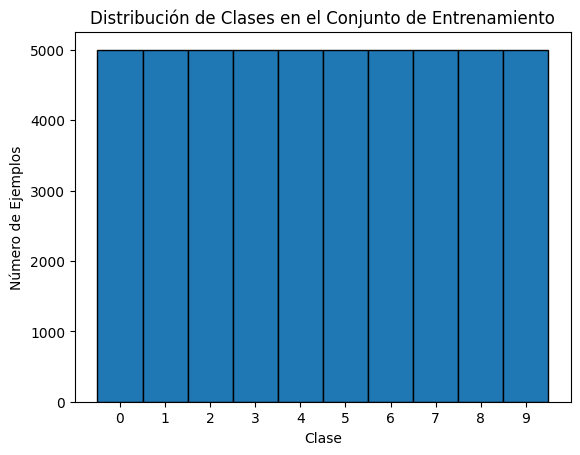

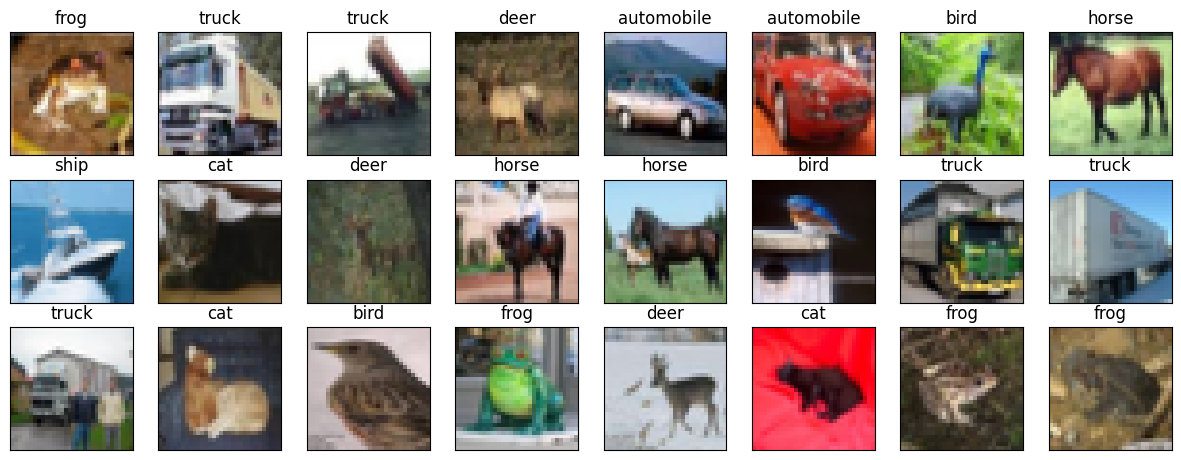

In [3]:
# Explorar la estructura de los datos
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)
print("Número de clases:", len(set(y_train.flatten())))

# Analizar la distribución de clases en el conjunto de datos
plt.hist(y_train, bins=range(11), edgecolor='black', align='left')
plt.xlabel('Clase')
plt.ylabel('Número de Ejemplos')
plt.title('Distribución de Clases en el Conjunto de Entrenamiento')
plt.xticks(range(10))
plt.show()

# CIFAR-10 clases
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Nueva figura
plt.figure(figsize=(15,15))

# Visualizar primeras 24 imágenes
for i in range(24):
    # Crear subplot de cada imagen
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Mostrar imagen
    plt.imshow(X_train[i])

    # Mostrar etiquete de la imagen
    plt.title(class_names[y_train[i][0]], fontsize=12)

# Visualizar la figura
plt.show()

* El conjunto de datos corresponde a 65.000 imágenes a color de 32 x 32 píxeles, 45.000 corresponden al conjunto de entrenamiento y 10.000 al conjunto de prueba, etiquetadas con 10 clases diferentes.

* La distribución de las clases se asemeja a una distribución uniforme, es decir, todos los valores tienen la misma propabilidad de ocurrencia.

### 3. Preparación de los datos para poder utilizarlos como entrada en modelos de deep learning.

#### División de los datos

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nValidation Images Shape: ', X_valid.shape)
print('Validation Labels Shape: ', y_valid.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (45000, 32, 32, 3)
Train Labels Shape:       (45000, 1)

Validation Images Shape:  (5000, 32, 32, 3)
Validation Labels Shape:  (5000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


#### Normalización de los datos

In [5]:
# Convertir los datos a float32
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_valid = X_valid.astype('float32')

# Calcular la media y la desviación estándar
mean = np.mean(X_train)
std  = np.std(X_train)

# Normalizar los datos
# El valor pequeño 1e-7 es agregado para prevedir la división por cero
X_train = (X_train-mean)/(std+1e-7)
X_test  = (X_test-mean) /(std+1e-7)
X_valid = (X_valid-mean)/(std+1e-7)

#### Codificación binaria de etiquetas

In [6]:
y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test  = to_categorical(y_test, 10)

#### Aumento de datos

In [7]:
data_generator = ImageDataGenerator(
    # Rotación de imágenes
    rotation_range=15,

    # Desplazamiento horizontal
    width_shift_range=0.12,

    # Desplazamiento vertical
    height_shift_range=0.12,

    # Volteo horizontal
    horizontal_flip=True,

    # Zoom
    zoom_range=0.1,

    # Rango de brillo
    brightness_range=[0.9,1.1],

    # Intensidad de Cizalladura
    shear_range=10,

    # Desplazamiento de canales
    channel_shift_range=0.1,
)

* El preprocesamiento de datos es fundamental cuando se trabaja con modelos de deep learning, ya que esto aumenta significativamente el desempeño del modelo.

* Se aplica la normalización Z-Score, convirtiendo los datos a float32 para poder realizar operaciones matemáticas más precisas y luego se normalizan los valores restando la media y dividiendo por la desviación estándar para centrar los datos en cero con una desviación estándar de uno. Reducir la magnitud de los números ayuda a prevenir problemas de estabilidad numérica durante el cálculo de gradientes, logrando que el modelo de deep learning funcione mejor y tenga un rendimiento más consistente.

* Se convierten las etiquetas categoricas en vectores binarios, esto es necesario para que el modelo procese las funciones de pérdida y optimización de manera adecuada, permitiendo que cada clase sea tratada de manera equitativa sin introducir un orden implícito entre las clases.

* Finalmente se aumenta el tamaño del conjunto de entrenamiento mediante la creación de versiones modificadas de imágenes en el conjunto de datos, aplicando técnicas como: rotación, desplazamiento horizontal y vertical, Volteo horizontal, zoom, rango de brillo, Intensidad de Cizalladura y desplazamiento de canales, aumentando la capacidad del modelo para generalizar, reduciendo así el sobreajuste.

### 4. Análisis sobre la selección del modelo de deep learning apropiado y la estrategia de estimación y calibración.

#### Modelo 1: Red Neuronal Convolucional

In [8]:
# Iniciar modelo secuencial
model = Sequential()

# Valor de caída de peso para la regularización L2
weight_decay = 0.0001

# Primera capa convolucional con 32 filtros de tamaño 3x3
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay),
                 input_shape=X_train.shape[1:]))
# Capa de normalización por lotes
model.add(BatchNormalization())

# Segunda capa convolucional similar a la primera
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Primera capa de agrupación máxima con un tamaño de agrupación de 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))
# Capa de abandono con una tasa de abandono de 0,2
model.add(Dropout(rate=0.2))

# Tercera y cuarta capas convolucionales con 64 filtros
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Segunda capa de agrupación máxima y tasa de abandono a 0,3
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.3))

# Quinta y sexta capa convolucional con 128 filtros
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Tercera capa de agrupación máxima y tasa de abandono a 0,4
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.4))

# Séptima y octava capas convolucionales con 256 filtros
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Cuarta capa de agrupación máxima y tasa de abandono a 0,5
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))

# Aplanar la salida de la capa anterior
model.add(Flatten())

# Capa completamente conectada con la función de activación softmax para generar probabilidades de clase
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                        

* La arquitectura de la red neuronal convolucional contiene capas convolucionales, seguidas de capas de agrupación máxima y de abandono, y finalmente una capa completamente conectada para clasificación multiclase con una estructura sencilla que lo hace más eficiente computacionalmente.

* La red comienza con un par de capas Conv2D, cada una con 32 filtros de tamaño 3x3. A esto le sigue una capa de Normalización por lotes que acelera el entrenamiento y proporciona cierto nivel de regularización, lo que ayuda a evitar el sobreajuste. Los pares de capas Conv2D van seguidos de una capa MaxPooling2D, que reduce las dimensiones espaciales (alto y ancho), proporcionando efectivamente una reducción de la complejidad computacional. A esto le sigue una capa de abandono que establece aleatoriamente una fracción (0,2 para la primera capa de abandono) para evitar el sobreajuste.

* Este patrón de dos capas Conv2D, seguidas de una capa de normalización por lotes, una capa MaxPooling2D y una capa de abandono, se repite tres veces más. La cantidad de filtros en las capas de Conv2D se duplica con cada repetición, comenzando desde 32 y subiendo hasta 64, 128 y luego 256. Este patrón creciente ayuda a la red a aprender características más complejas en cada nivel. La tasa de abandono también aumenta en cada paso, de 0,2 a 0,5.

* Después de las capas convolucional y de agrupación, se utiliza una capa Aplanar para convertir las salidas 2D de la capa anterior en un vector 1D.

* Finalmente, se utiliza una capa Densa (o completamente conectada) para la clasificación. Tiene 10 unidades, cada una de las cuales representa una de las 10 clases del conjunto de datos CIFAR-10, y se utiliza una función de activación softmax para convertir los resultados en puntuaciones de probabilidad para cada clase. Esta arquitectura aprovecha las fortalezas de las CNN profundas para aprender características jerárquicas de las imágenes CIFAR-10. Las técnicas de regularización como la regularización L2, la deserción y la normalización por lotes también se utilizan para combatir el sobreajuste.

#### Modelo 2: Transfer Learning

In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
import tensorflow as tf

# Cargar el modelo VGG16 pre-entrenado sin las capas de clasificación superior
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Congelar las capas base del modelo
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores para la clasificación
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

# Crear el modelo final
model_tl = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model_tl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model_tl.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

* Los modelos con los que se podría abordar el problema de interés deben cumplir con los siguientes criterios:

1. Capacidad de clasificación multiclase
2. Eficiencia computacional
3. Robustez y generalización
4. Adaptabilidad

**Modelos candidatos:**

**1. Redes Neuronales Convolucionales**

* Esta podría ser la opción más específica para tareas de clasificación de imágenes debido a su capacidad para capturar características espaciales y patrones locales en las imágenes.

* Las CNNs son naturalmente adecuadas para la tarea de clasificación de imágenes debido a su capacidad para manejar datos de alta dimensión y su habilidad para aprender características jerárquicas. Modelos como VGGNet, ResNet y DenseNet han demostrado un rendimiento superior en benchmarks de visión por computadora y son buenos puntos de partida.

**2. Transfer Learning**

* Utilizar modelos preentrenados en grandes conjuntos de datos (como ImageNet) y ajustar (fine-tuning) las capas finales para la tarea específica de clasificación en CIFAR-10.

* Utilizar modelos preentrenados puede acelerar el proceso de entrenamiento y mejorar el rendimiento, especialmente cuando se dispone de recursos computacionales limitados. Modelos como InceptionV3 y EfficientNet son candidatos prometedores debido a su equilibrio entre precisión y eficiencia.

### 5. Desarrollo y calibración de modelos.

#### Modelo 1: Red Neuronal Convolucional

In [10]:
# Tamaño del lote
batch_size = 64

# Número de epocas
epochs = 100

# Optimizador Adam
optimizer = Adam(learning_rate=0.0005)

# Parámetros de compilación del modelo
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Definición del callback ReduceLROnPlateau, para ajustar la tasa de aprendizaje del optimizador durante el entrenamiento
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

# Definición del callback EarlyStopping, para detener el entrenamiento del modelo de manera anticipada
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Entrenamiento y parámetros del modelo
history = model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
          epochs=epochs,
          validation_data=(X_valid, y_valid),
          callbacks=[reduce_lr, early_stopping],
          verbose=2)

Epoch 1/100
704/704 - 64s - loss: 2.3199 - accuracy: 0.3408 - val_loss: 1.7170 - val_accuracy: 0.4542 - lr: 5.0000e-04 - 64s/epoch - 91ms/step
Epoch 2/100
704/704 - 48s - loss: 1.7354 - accuracy: 0.4677 - val_loss: 1.4677 - val_accuracy: 0.5410 - lr: 5.0000e-04 - 48s/epoch - 69ms/step
Epoch 3/100
704/704 - 47s - loss: 1.5128 - accuracy: 0.5362 - val_loss: 1.5782 - val_accuracy: 0.5474 - lr: 5.0000e-04 - 47s/epoch - 67ms/step
Epoch 4/100
704/704 - 46s - loss: 1.3692 - accuracy: 0.5792 - val_loss: 1.3959 - val_accuracy: 0.5864 - lr: 5.0000e-04 - 46s/epoch - 66ms/step
Epoch 5/100
704/704 - 47s - loss: 1.2277 - accuracy: 0.6191 - val_loss: 1.1576 - val_accuracy: 0.6364 - lr: 5.0000e-04 - 47s/epoch - 67ms/step
Epoch 6/100
704/704 - 46s - loss: 1.1412 - accuracy: 0.6456 - val_loss: 1.1070 - val_accuracy: 0.6600 - lr: 5.0000e-04 - 46s/epoch - 65ms/step
Epoch 7/100
704/704 - 46s - loss: 1.0607 - accuracy: 0.6742 - val_loss: 1.1476 - val_accuracy: 0.6602 - lr: 5.0000e-04 - 46s/epoch - 65ms/step

* Se entrena el modelo de red neuronal parametrizando un tamaño de lote de 64 y durante un máximo de 100 épocas o hasta que se cumpla la condición de parada temprana. Durante el entrenamiento, el rendimiento del modelo se evalúa en los datos de validación después de cada época. Se agrega un par de funciones de devolución de llamada para mejorar el proceso.

* El callback ReduceLROnPlateau se utiliza para reducir la tasa de aprendizaje a la mitad (factor = 0,5) siempre que la pérdida de validación no mejora durante 10 épocas consecutivas. Esto ayuda a ajustar dinámicamente la tasa de aprendizaje, lo que permite que el modelo se acerque al mínimo global de la función de pérdida cuando el progreso se ha estancado.

* El callback EarlyStopping se emplea para monitorear la pérdida de validación y detener el proceso de entrenamiento cuando no ha habido ninguna mejora durante 10 épocas, asegurando que el modelo no desperdicie tiempo y recursos computacionales. Además, este callback restaura los mejores pesos del proceso de entrenamiento, asegurando que concluyamos con la configuración óptima del modelo.

#### Modelo 2: Transfer Learning

In [11]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

# Entrenar el modelo
history_tl = model_tl.fit(
    data_generator.flow(X_train, y_train, batch_size=64),
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks
)

Epoch 1/100
704/704 [==============================] - 55s 75ms/step - loss: 1.5088 - accuracy: 0.4633 - val_loss: 1.1250 - val_accuracy: 0.6082
Epoch 2/100
704/704 [==============================] - 51s 73ms/step - loss: 1.3065 - accuracy: 0.5448 - val_loss: 1.0749 - val_accuracy: 0.6306
Epoch 3/100
704/704 [==============================] - 51s 72ms/step - loss: 1.2534 - accuracy: 0.5629 - val_loss: 1.0342 - val_accuracy: 0.6412
Epoch 4/100
704/704 [==============================] - 51s 72ms/step - loss: 1.2231 - accuracy: 0.5739 - val_loss: 1.0260 - val_accuracy: 0.6374
Epoch 5/100
704/704 [==============================] - 50s 71ms/step - loss: 1.1961 - accuracy: 0.5817 - val_loss: 0.9928 - val_accuracy: 0.6594
Epoch 6/100
704/704 [==============================] - 50s 71ms/step - loss: 1.1831 - accuracy: 0.5878 - val_loss: 0.9887 - val_accuracy: 0.6598
Epoch 7/100
704/704 [==============================] - 50s 71ms/step - loss: 1.1692 - accuracy: 0.5918 - val_loss: 0.9842 - val_ac

#### Evaluación del modelo en test

In [12]:
# Evaluación de datos en test red convolucional
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

313/313 [==============================] - 1s 5ms/step - loss: 0.6037 - accuracy: 0.8654

Test Accuracy: 0.8654000163078308
Test Loss:     0.6037259697914124


In [13]:
# Evaluación de datos en test Transfer Learning
test_loss, test_acc_tl = model_tl.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy Tranfer Learning:', test_acc)
print('Test Loss Transfer Learning:    ', test_loss)


313/313 [==============================] - 3s 9ms/step - loss: 0.9393 - accuracy: 0.6740

Test Accuracy Tranfer Learning: 0.8654000163078308
Test Loss Transfer Learning:     0.939300000667572


### 6. Visualización de resultados.

#### Modelo 1: Red Neuronal Convolucional

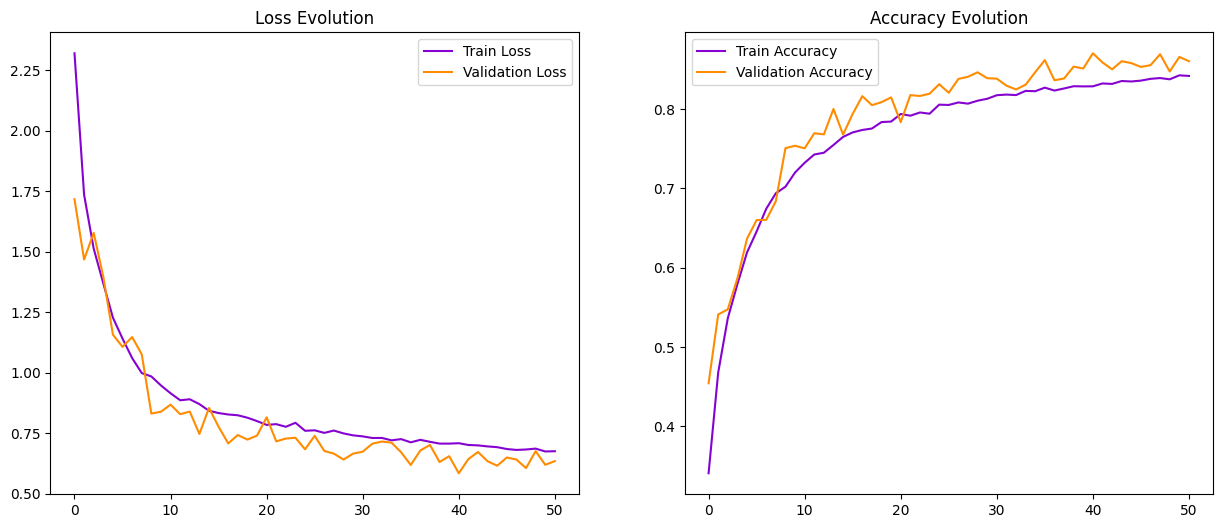

In [14]:
plt.figure(figsize=(15,6))

# Traza la pérdida de entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Traza la precisión de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

In [15]:
model_tl.history.history

{}

* Según las visualizaciones anteriores, es evidente que el modelo funciona bien sin signos de sobreajuste. Esta conclusión está respaldada por la estrecha alineación de los valores de precisión y pérdida de entrenamiento y validación a lo largo del proceso de entrenamiento. La brecha entre la precisión del entrenamiento y la validación sigue siendo mínima, lo que indica que el modelo se generaliza bien a datos no vistos. De manera similar, la pérdida del modelo en los datos de validación sigue de cerca la pérdida de entrenamiento, lo que refuerza la afirmación de una buena generalización. Por lo tanto, el modelo parece estar bien regularizado y no sobreajustado a los datos de entrenamiento.

#### Modelo 2: Transfer Learning

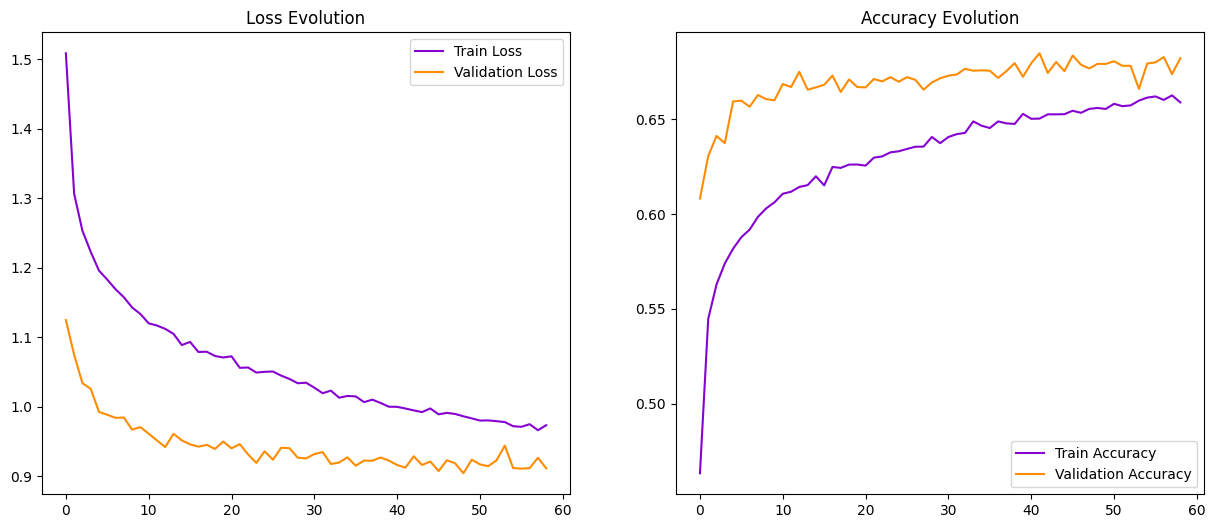

In [16]:
plt.figure(figsize=(15,6))

# Traza la pérdida de entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(history_tl.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(history_tl.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Traza la precisión de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history_tl.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(history_tl.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

### 7. Implementación y demostración de la utilidad de los resultados.

Predicciones con el primer modelo:
1/1 [==============================] - 1s 913ms/step


URL: https://images.pexels.com/photos/46148/aircraft-jet-landing-cloud-46148.jpeg
Predicted class:  airplane


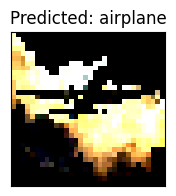

1/1 [==============================] - 0s 19ms/step
URL: https://img.freepik.com/foto-gratis/vista-coche-3d_23-2150796894.jpg
Predicted class:  automobile


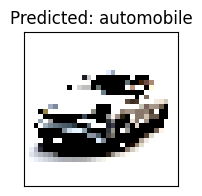

1/1 [==============================] - 0s 19ms/step


URL: https://images.pexels.com/photos/1661179/pexels-photo-1661179.jpeg
Predicted class:  bird


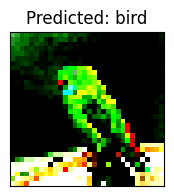

Predicciones con el segundo modelo:
1/1 [==============================] - 0s 19ms/step


URL: https://images.pexels.com/photos/46148/aircraft-jet-landing-cloud-46148.jpeg
Predicted class:  airplane


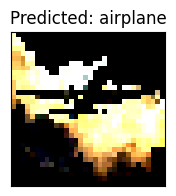

1/1 [==============================] - 0s 18ms/step
URL: https://img.freepik.com/foto-gratis/vista-coche-3d_23-2150796894.jpg
Predicted class:  automobile


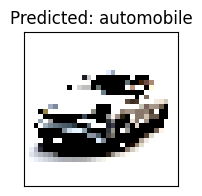

1/1 [==============================] - 0s 18ms/step


URL: https://images.pexels.com/photos/1661179/pexels-photo-1661179.jpeg
Predicted class:  frog


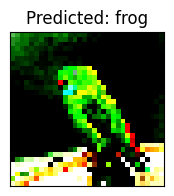

In [20]:


urls = [
    'https://images.pexels.com/photos/46148/aircraft-jet-landing-cloud-46148.jpeg',
    'https://img.freepik.com/foto-gratis/vista-coche-3d_23-2150796894.jpg',
    'https://images.pexels.com/photos/1661179/pexels-photo-1661179.jpeg'
]


def preprocess_image(url):
    req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    resp = urllib.request.urlopen(req)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (32, 32))
    image = (image - mean) / (std + 1e-7)  # Normalizar los datos de la imagen
    image = np.expand_dims(image, axis=0)  # Agregar dimensión adicional porque el modelo espera un lote de imágenes
    return image

def predict_with_model(urls, model):
    for url in urls:
        try:
            image = preprocess_image(url)
            prediction = model.predict(image)
            predicted_class = prediction.argmax()
            print(f'URL: {url}')
            print('Predicted class: ', class_names[predicted_class])
            plt.figure(figsize=(2, 2))
            plt.imshow(image[0])
            plt.title(f'Predicted: {class_names[predicted_class]}')
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.show()
        except Exception as e:
            print(f'Error processing {url}: {e}')

# Predecir con el primer modelo
print("Predicciones con el primer modelo:")
predict_with_model(urls, model)

# Predecir con el segundo modelo
print("Predicciones con el segundo modelo:")
predict_with_model(urls, model_tl)


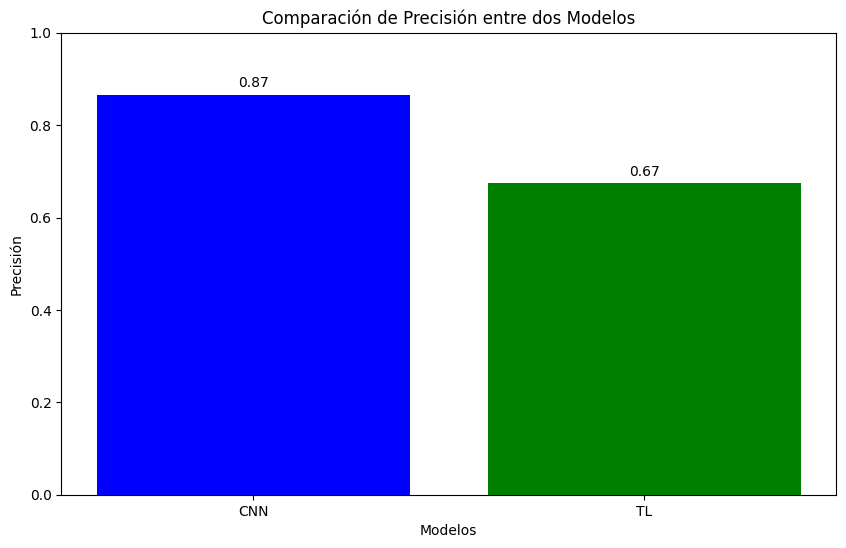

In [18]:
# Nombres de los modelos
model_names = ['CNN', 'TL']

# Valores de precisión
accuracies = [test_acc, test_acc_tl]

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['blue', 'green'])
plt.ylim(0, 1)  # El rango de precisión es de 0 a 1
plt.xlabel('Modelos')
plt.ylabel('Precisión')
plt.title('Comparación de Precisión entre dos Modelos')

# Añadir el valor de la precisión encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.show()


* Con una precisión de prueba de más del 87%, la red neuronal convolucional demuestra un rendimiento alto en datos de prueba, lograda con un modelo de apenas alrededor de 1,2 millones de parámetros. La proximidad de la pérdida de prueba y la precisión a sus respectivas contrapartes de entrenamiento significa que el modelo no simplemente memoriza los datos de entrenamiento, sino que realmente comprende patrones y generaliza de manera efectiva desde los datos de entrenamiento a datos de prueba. Por lo tanto, se puede inferir que el modelo no solo ofrece predicciones confiables sino que también logra un equilibrio entre eficiencia y desempeño.

* Al evaluar la precisión y eficiencia de los modelos predictivos implementados en la clasificación de imágenes del conjunto de datos CIFAR_10, la red neuronal convolucional destaca por encima del transfer learning, de lo cual podemos inferir que se podría implementar el modelo en aplicaciones de visión por computadora.

* Algunas aplicaciones prácticas serían sistemas de reconocimiento de objetos en tiempo real o en la industria automotriz para sistemas de asistencia a la conducción.

* Las limitaciones de este tipo de modelos son el tiempo de entrenamiento y consumo alto de recursos computacionales, así como  el riesgo de sobreajuste en conjuntos de datos pequeños, la sensibilidad a ciertas clases o características de las imágenes, o la necesidad de más datos de entrenamiento para mejorar la generalización.

* Los desafíos que se presentan son la optimización de la arquitectura del modelo, la selección adecuada de hiperparámetros, o la gestión de conjuntos de datos desequilibrados.

* Finalmente, para futuras investigaciones se podría incluir investigaciones sobre nuevas técnicas de regularización, el diseño de arquitecturas de redes neuronales más eficientes, o el estudio de métodos para interpretar y explicar las decisiones de los modelos de aprendizaje profundo.